#### Labels transfer of cell states from gut healthy adult single-cell RNA sequencing cells to Xenium add-on panel data with `scANVI`
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 31th July 2024
- **Last modified date:** 31th July 2024

##### Import packages

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [5]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [6]:
input = 'data/Healthy_colon_adult.h5ad'
adata_ref = sc.read_h5ad(input)

In [7]:
X_is_raw(adata_ref)

True

In [8]:
adata_xenium = sc.read_10x_h5('data/10X_Xenium_adult_colon_data/raw_files/10X_Xenium_raw.h5ad')

reading data/10X_Xenium_adult_colon_data/cell_feature_matrix.h5
 (0:00:00)


In [9]:
X_is_raw(adata_xenium)

True

### Prepare reference dataset

+ Save raw counts

In [10]:
adata_ref.raw = adata_ref

In [11]:
adata_xenium.raw = adata_xenium

+ prepare xenium data

In [12]:
adata_xenium.obs['seed_labels'] = 'Unknown'

In [13]:
adata_xenium.obs['Donor_ID'] = 'Xenium_donor_1'

In [14]:
adata_xenium.obs['Library_Preparation_Protocol'] = 'Xenium'

In [15]:
adata_xenium.obs['Study_name'] = '10X_Xenium_gut_data'

+ Concatenate datasets

In [16]:
adata = adata_ref.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)

#### Run scVI

In [17]:
adata.layers['counts'] = adata.X.copy()

In [18]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Donor_ID', 
                                                          'Library_Preparation_Protocol', 
                                                          'Study_name'],
                              labels_key = "seed_labels", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [19]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [20]:
scvi_model.train(200, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 200/200: 100%|██████████| 200/200 [1:03:26<00:00, 19.89s/it, v_num=1, train_loss_step=122, train_loss_epoch=108]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [1:03:26<00:00, 19.03s/it, v_num=1, train_loss_step=122, train_loss_epoch=108]


In [21]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

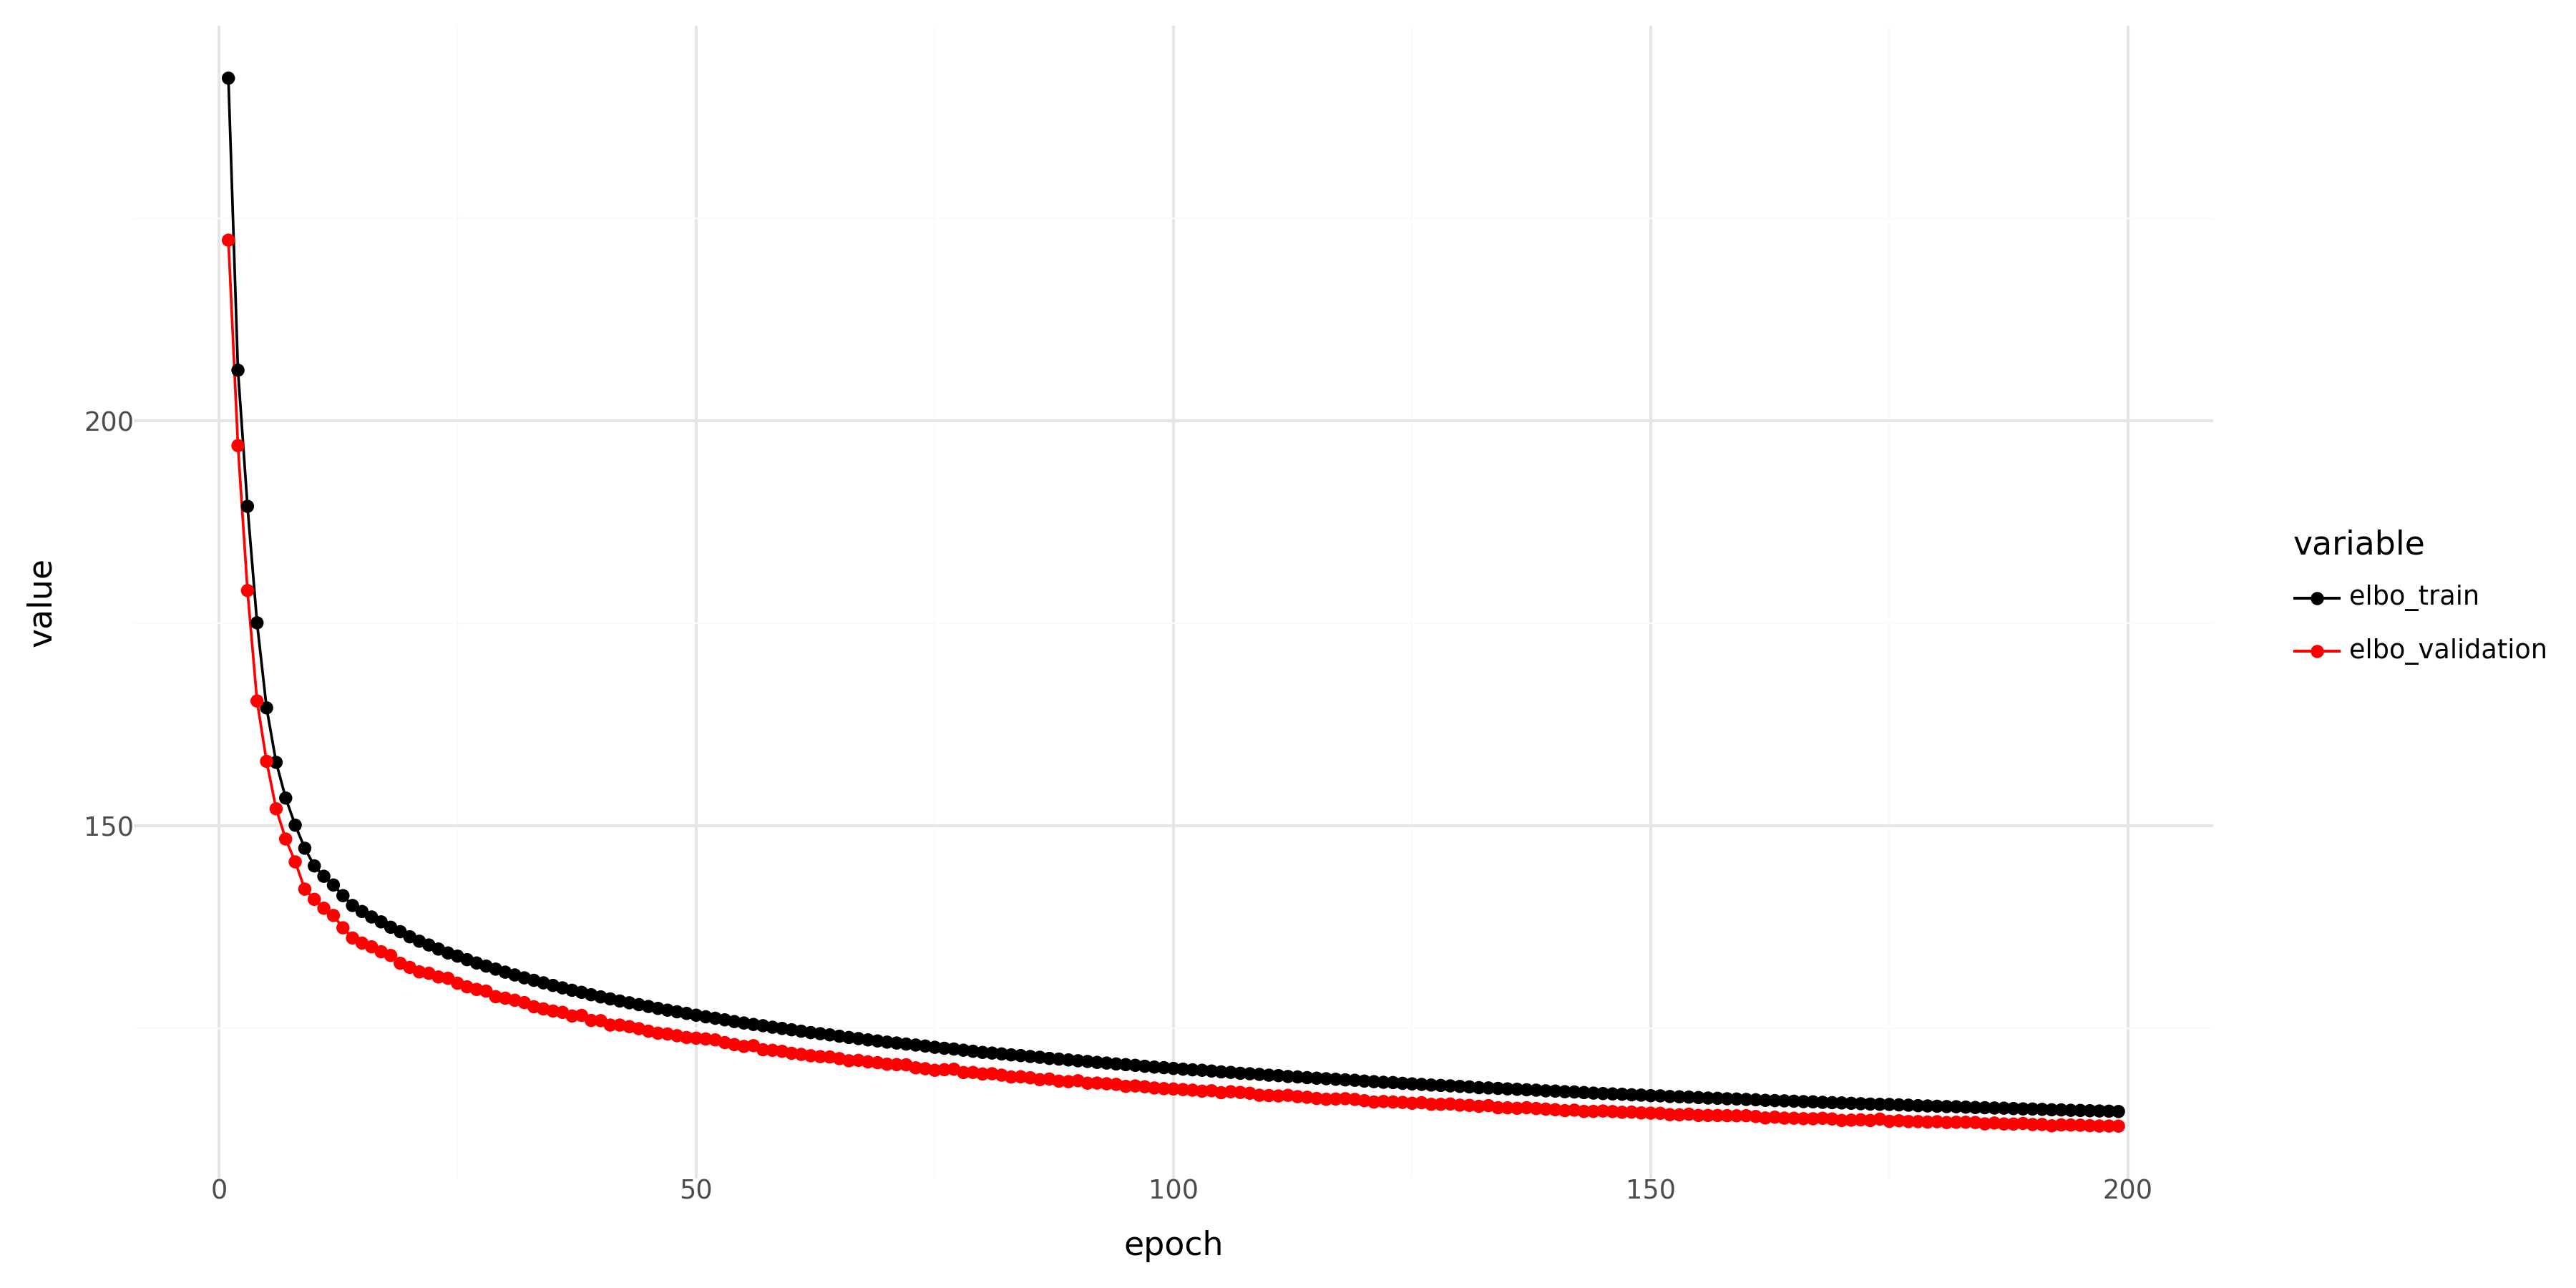

In [22]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [24]:
scanvi_model.train(200, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 200/200: 100%|██████████| 200/200 [3:07:56<00:00, 57.69s/it, v_num=1, train_loss_step=129, train_loss_epoch=118]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [3:07:56<00:00, 56.38s/it, v_num=1, train_loss_step=129, train_loss_epoch=118]


In [25]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [26]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

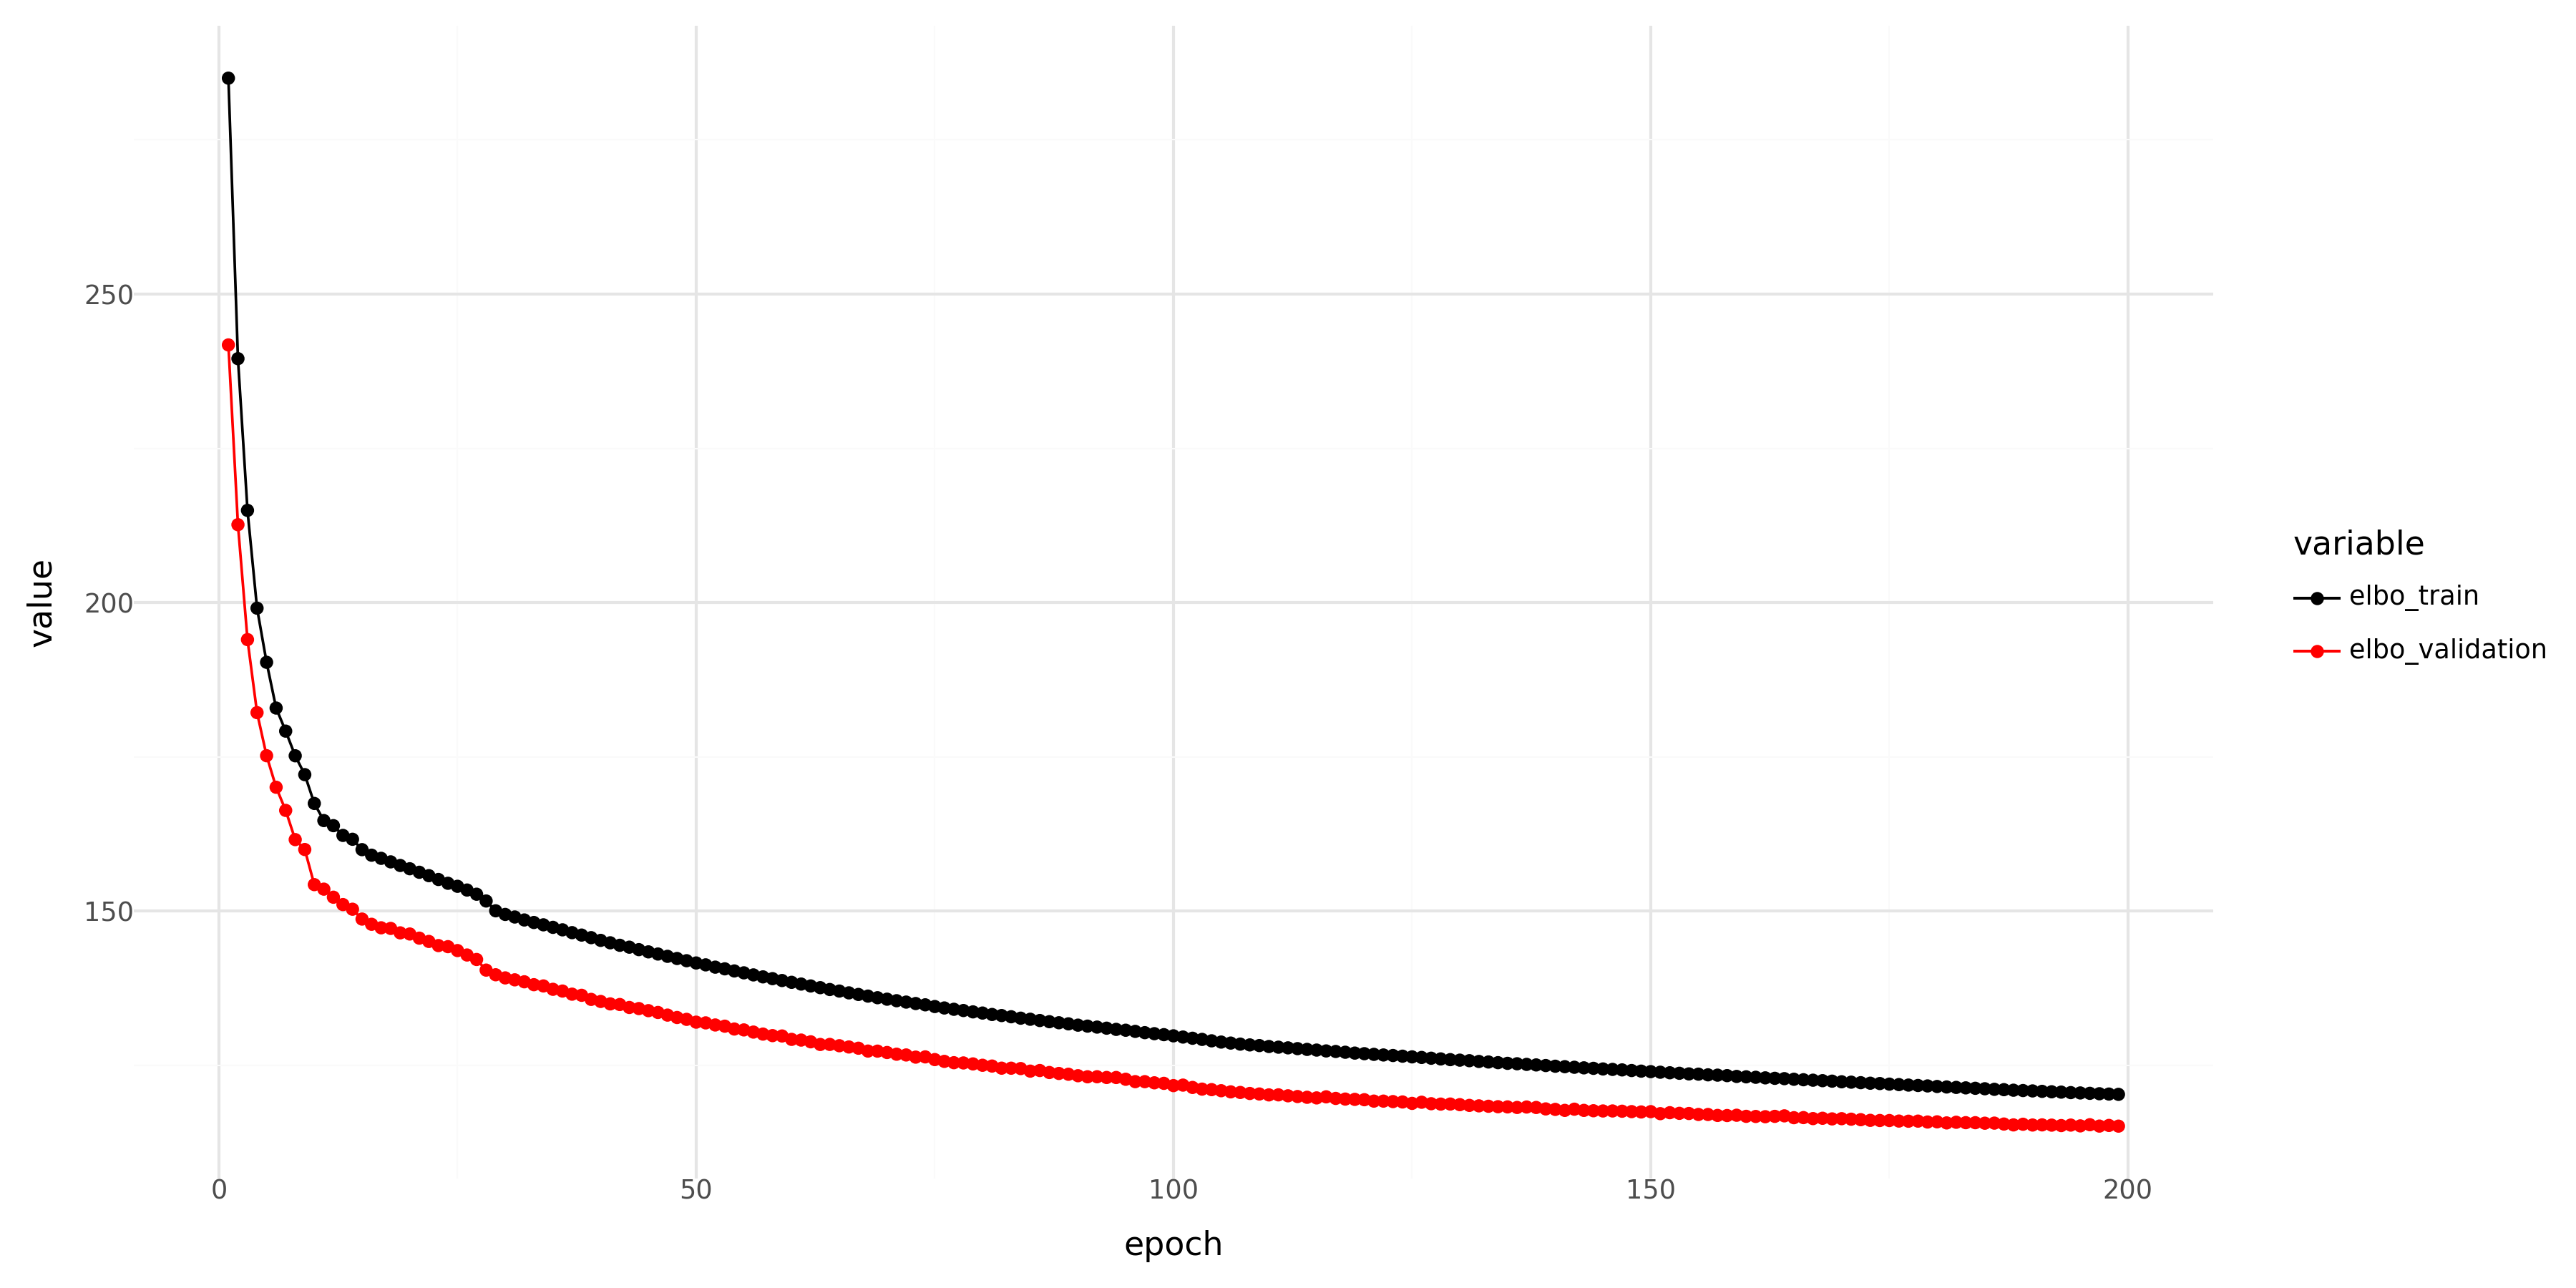

In [27]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

+ Visualize dataset

In [28]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:04:55)


In [29]:
adata.obs['C_scANVI'].value_counts()

C_scANVI
Enterocyte              61991
Plasma cells            56861
Fibroblasts             48733
Myofibroblasts          43402
TA                      33985
Stem cells              32899
Colonocyte              28973
CD4 T                   27075
Goblet cells            24441
Macrophages             22508
B cells                 17558
CD8 T                   10745
BEST4+ epithelial       10466
Glial cells              9329
Endothelial cells        9163
Pericytes                6828
Mast cells               6506
Tuft cells               6023
DC                       5485
EECs                     4429
Mature venous EC         4037
arterial capillary       3393
Mature arterial EC       2836
Monocytes                2019
NK                       1391
LEC                      1135
Immune Cycling cells      741
gdT                       656
Lymphatics                340
ILCs                      266
Tregs                     187
Microfold cell            174
Adult Glia                 16
M

In [30]:
sc.set_figure_params(dpi = 300, figsize=(10,7))
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'Library_Preparation_Protocol', 'C_scANVI', 'Donor_ID'], ncols = 2, frameon = False, size = 1)

In [31]:
adata_filtered = adata[adata.obs['dataset'] == 'query']

In [32]:
adata_filtered.obs['C_scANVI'].value_counts()

C_scANVI
Myofibroblasts          41951
Fibroblasts             34090
Enterocyte              31962
Colonocyte              20706
Plasma cells            18744
Stem cells              14880
Macrophages             14703
Goblet cells            12636
B cells                 12046
CD4 T                   11784
Glial cells              7958
Endothelial cells        7191
TA                       6118
BEST4+ epithelial        5851
Pericytes                5838
Tuft cells               4813
Mast cells               3836
EECs                     3786
DC                       3498
arterial capillary       3242
Mature venous EC         2566
CD8 T                    2143
Mature arterial EC       1994
Monocytes                1786
LEC                       774
NK                        481
Immune Cycling cells      192
Lymphatics                100
Microfold cell             95
Tregs                      28
ILCs                       18
gdT                         6
Adult Glia                  5
M

In [33]:
df = adata_filtered.obs['C_scANVI'].value_counts()

In [34]:
adata_filtered.write_h5ad('data/10X_Xenium_adult_colon_data/Annotation_prediction/Xenium_cell_states_161024.h5ad')

In [36]:
adata.write_h5ad('data/10X_Xenium_adult_colon_data/Annotation_prediction/Xenium_and_reference.h5ad')

### Check the integration metrics with `scIB`

The following code takes more than 12 hours to run so I run it separately in .py file using tmux. The resulted metrics can be found in the figure folder, file cell_states_scIB.png.

In [ ]:
bm = Benchmarker(
    adata,
    batch_key='Donor_ID',
    label_key='C_scANVI',
    embedding_obsm_keys=['X_scANVI', 'X_scVI', 'X_pca', 'X_umap'],
    n_jobs=-1
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)